# In this Lesson:
#### First task in self driving cars is to enable car to detect lane lines in roads.

So our `goal` is to create a software that have some input data (images from camera in our case) and detect where the lane lines are.

#### Contents:
[1. Color Selection](#color_selection)<br>
[2. Selecting Region of Interest](#ROI)<br>
[3. Canny Edge Detection](#canny)<br>
[4. Line Hough Transform](#hough)

<a id='color_selection'></a>

# Color Selection

<font size=3>To detect lanes in images, one of the logical ways is to select colors of lanes in image and discard other parts, as we see in below image almost lanes colors are <font color='red'><strong>white</strong></font>, So if we can select only white lines in image and discard other colors, then we may detect lanes correctly.
</font>
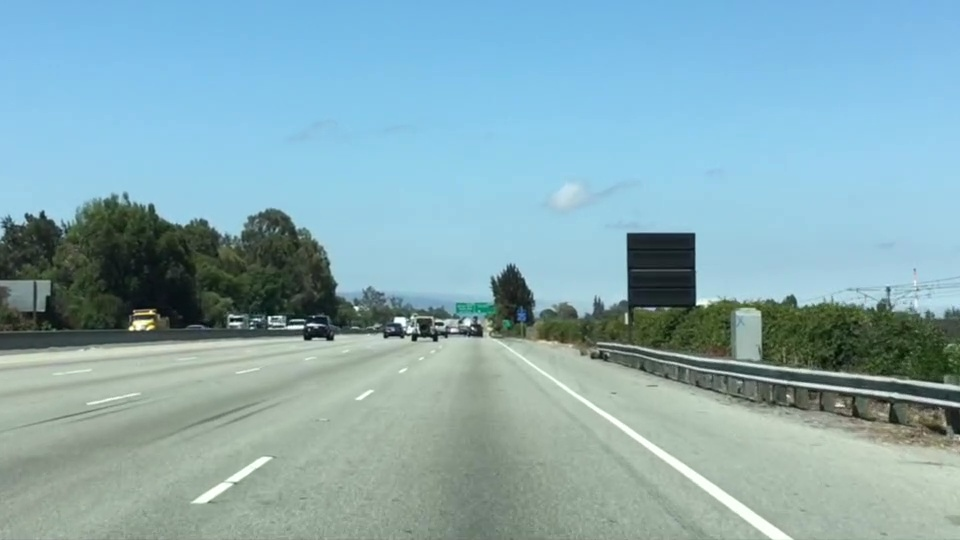

In [1]:
# Imports
import os
import cv2 as cv
import pathlib
import numpy as np
from matplotlib import pyplot as plt

# configurations
IMAGE_DIR = "part 01-module 01-lesson 03/img/"

while "part 01-module 01-lesson 03" in pathlib.Path.cwd().parts:
    os.chdir('..')

from utils import * 

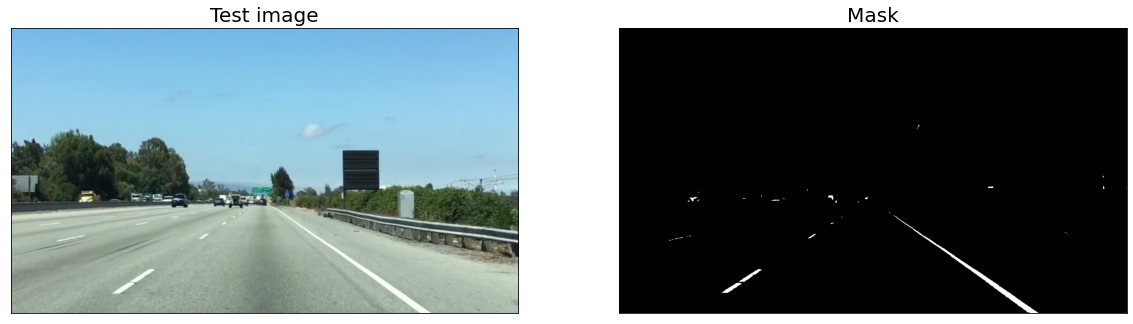

In [26]:
test_img_path = IMAGE_DIR + "test.jpg"

test_img = cv.imread(test_img_path)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)

mask = np.zeros_like(test_img)
THRESHOLD = 245
mask[(test_img[:, :, 0]>=THRESHOLD) \
     | (test_img[:, :, 1]>=THRESHOLD) \
     | (test_img[:, :, 2]>=THRESHOLD)] = [255, 255, 255]

image_grid(1, 2, [test_img, mask], titles=['Test image', 'Mask'])

<a id=ROI></a>
# Selecting Region of Interest


### Coding up a Region of Interest Mask

Awesome! Now you've seen that with a simple color selection we have managed to eliminate almost everything in the image except the lane lines.

At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

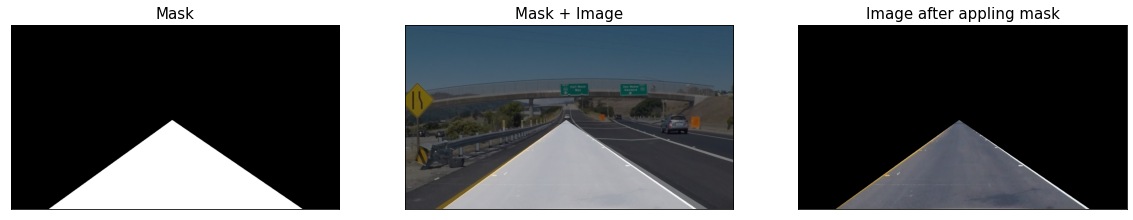

In [16]:
apex = 470, 280
left_corner = 110, 540
right_corner = 850, 540

painting = np.zeros_like(test_img)
corners = [left_corner, apex, right_corner]
corners = np.array(corners).reshape(-1, 1, 2)
painting = cv.fillPoly(painting, pts=[corners], color=(255, 255, 255))

img_painting = cv.addWeighted(test_img, 0.5, painting, 0.5, 1)
applied_mask = cv.bitwise_and(test_img, test_img, mask=painting[:, :, 0])

image_grid(1, 3, [painting, img_painting, applied_mask],
           titles=['Mask', 'Mask + Image', 'Image after appling mask'], fontsize=15)

<font size=3>
So we found the lane line.

As it happens, lane lines are not always the same color, and even lines of the same color under different lighting conditions (day, night, etc) may fail to be detected by our simple color selection.

What we need is to take our algorithm to the next level to detect lines of any color using sophisticated computer vision methods.
</font>

We will use `Canny Edge detection` algorithm to detect lane lines in image, For more details about canny edge detection check this [notebook](https://github.com/MahmoudEl-Husseni/Udacity-Introduction-to-Computer-Vision/blob/master/Udacity_Image%20processing_01.ipynb)

We'll also include Gaussian smoothing, before running Canny, which is essentially a way of suppressing noise and spurious gradients by averaging.

<a id='canny'></a>
# Canny Edge Detection

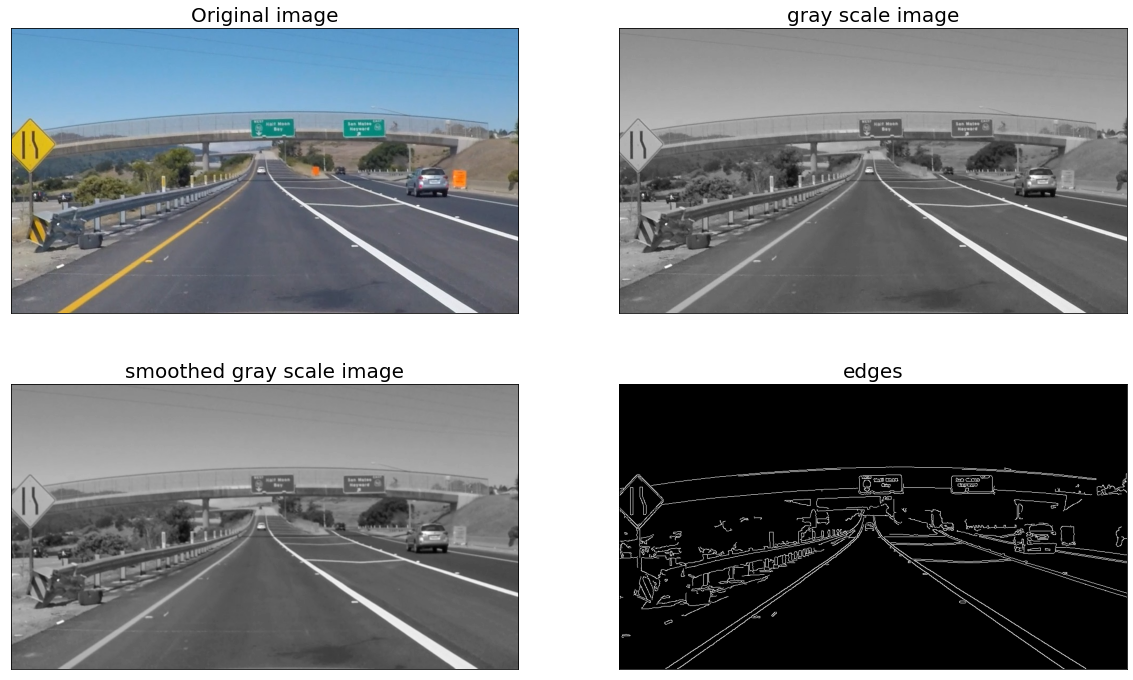

In [24]:
gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)

# Gaussian smoothing
gray_blur = cv.GaussianBlur(gray, (3, 3), 0)

# canny detection
lower_thresh, higher_thresh = 100, 300
edges = cv.Canny(test_img, lower_thresh, higher_thresh)

titles = ['Original image', 'gray scale image', 'smoothed gray scale image', 'edges']
image_grid(2, 2, [test_img, gray, gray_blur, edges], titles=titles)

<a id='hough'></a>
# Line Hough Transform 

So, We have detected edges in images but we should focus only on line edges, so we need an algorithm to select only lines from the corners.

We are going to use line hough transform to find lane lines, for more details about hough transform and how it works check this [notebook](https://github.com/MahmoudEl-Husseni/Udacity-Introduction-to-Computer-Vision/blob/master/Udacity_Image%20processing_02.ipynb) 

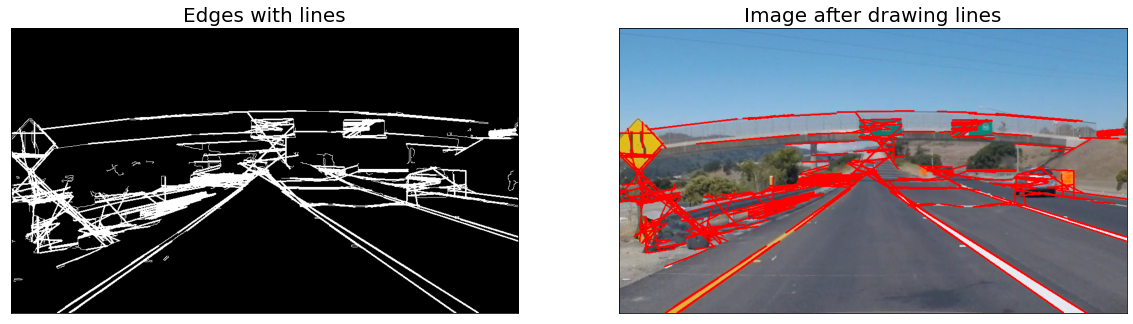

In [25]:
rho = 2
theta = np.pi / 180
threshold = 15
min_line_length = 40
max_line_gap = 20

lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
img_with_lines = draw_lines_end_points(test_img, lines, thickness=2)
edges_with_lines = draw_lines_end_points(edges, lines, thickness=2)

image_grid(1, 2, [edges_with_lines, img_with_lines], titles=['Edges with lines', 'Image after drawing lines'])

It seems better to search for lines in out region of interest to filter all other lines

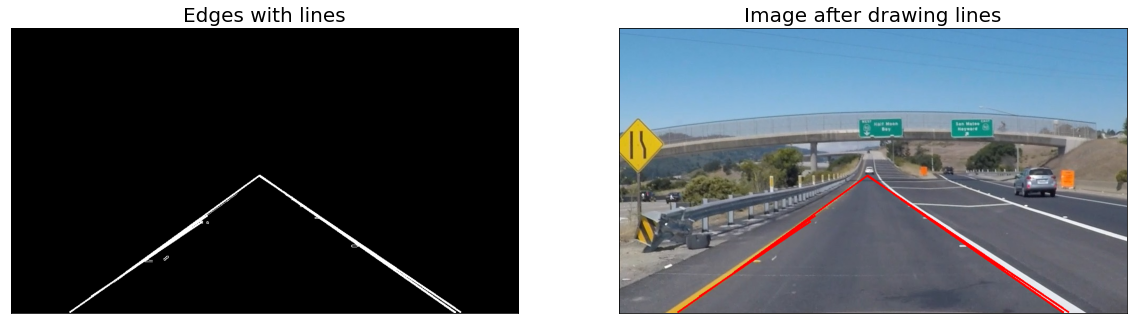

In [19]:
gray = cv.cvtColor(applied_mask, cv.COLOR_RGB2GRAY)

# Gaussian smoothing
gray_blur = cv.GaussianBlur(gray, (3, 3), 0)

# canny detection
lower_thresh, higher_thresh = 50, 150
edges = cv.Canny(gray_blur, lower_thresh, higher_thresh)

threshold = 100
max_line_gap = 100

lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
img_with_lines = draw_lines_end_points(test_img, lines, thickness=2)
edges_with_lines = draw_lines_end_points(edges, lines, thickness=2)

image_grid(1, 2, [edges_with_lines, img_with_lines], titles=['Edges with lines', 'Image after drawing lines'])